# **Import Dataset**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


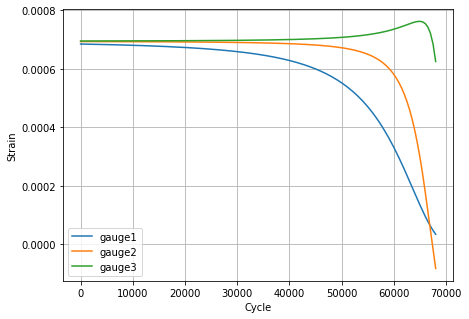

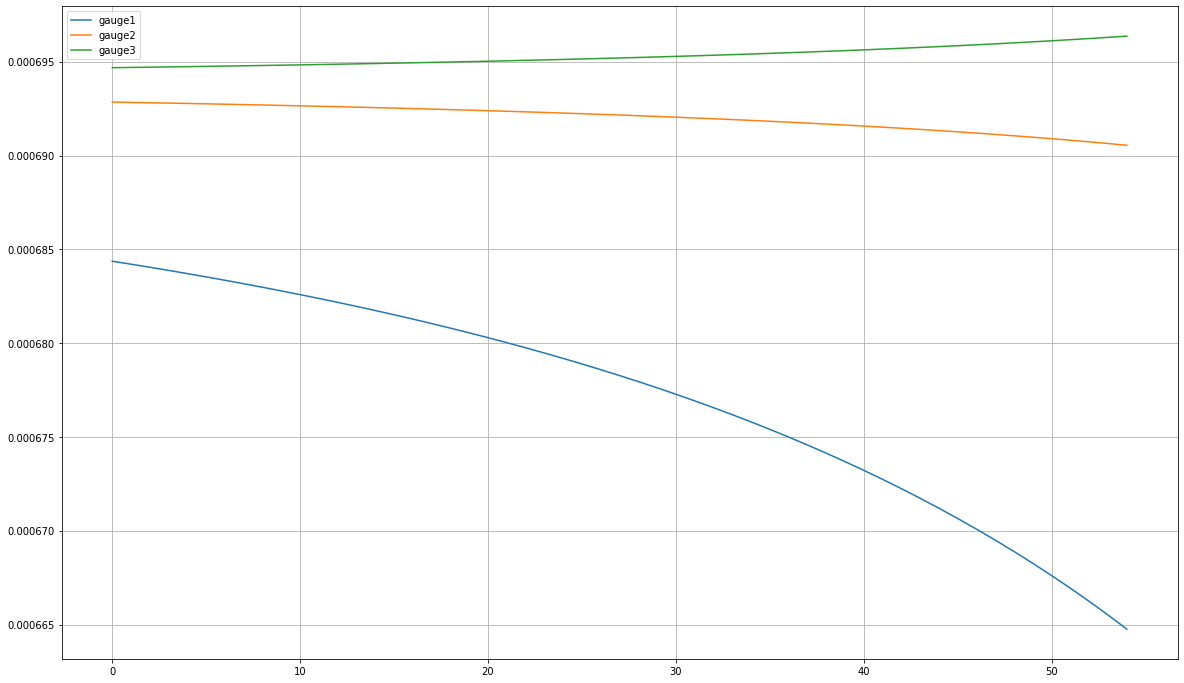

In [32]:
!pip3 install pickle5
import pickle5 as pc

from google.colab import drive
drive.mount('/content/drive')


import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
from datetime import datetime
import tensorflow as tf

# set random seed for random weights
np.random.seed(1)
tf.random.set_seed(1)
fd='/content/drive/MyDrive/PIR_perso'
fk='/data'
with open(fd + fk + '/data_train_v1', "rb") as fh:
  data_train = pc.load(fh).reset_index().iloc[:,1:]
with open(fd + fk +'/data_test_v1', "rb") as fh:
  data_test = pc.load(fh).reset_index().iloc[:,1:]

#data_train[data_train.ID == 1]

fig, ax = plt.subplots(figsize=(7,5))

ax.plot(data_train[data_train.ID == 1]['cycle'],data_train[data_train.ID == 1]['gauge1'],label= 'gauge1')
ax.plot(data_train[data_train.ID == 1]['cycle'],data_train[data_train.ID == 1][ 'gauge2'],label= 'gauge2')
ax.plot(data_train[data_train.ID == 1]['cycle'],data_train[data_train.ID == 1]['gauge3'], label= 'gauge3')
ax.grid()
ax.legend()

ax.set(xlabel='Cycle', ylabel='Strain')

plt.savefig('training_data_ID_1.pdf', bbox_inches='tight')

plt.show()

#data_train.head(10)

#data_test[data_test.ID==1]

plt.figure(figsize=(20, 12))
plt.plot(data_test[data_test.ID == 1]['gauge1'],label= 'gauge1')
plt.plot(data_test[data_test.ID == 1][ 'gauge2'],label= 'gauge2')
plt.plot(data_test[data_test.ID == 1]['gauge3'], label= 'gauge3')
plt.grid()
plt.legend()
plt.show()

# **Categorize Data**

count    1.385083e+06
mean     3.477047e+04
std      2.023644e+04
min      0.000000e+00
25%      1.731200e+04
50%      3.462700e+04
75%      5.193900e+04
max      8.189600e+04
Name: RUL, dtype: float64
count     8782.000000
mean     45427.648144
std      15643.733322
min       3964.000000
25%      34177.000000
50%      46891.000000
75%      57867.500000
max      79327.000000
Name: RUL, dtype: float64
[    0.           221.6066482    886.4265928   1994.4598338
  3545.70637119  5540.16620499  7977.83933518 10858.72576177
 14182.82548476 17950.13850416 22160.66481994 26814.40443213
 31911.35734072 37451.52354571 43434.90304709 49861.49584488
 56731.30193906 64044.32132964 71800.55401662 80000.        ]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


,ID,cycle,gauge1,gauge2,gauge3,RUL,RUL_bins
0,1,0,0.000684,0.000693,0.000695,68053,17
1,1,500,0.000684,0.000693,0.000695,67553,17
2,1,1000,0.000684,0.000693,0.000695,67053,17
3,1,1500,0.000684,0.000693,0.000695,66553,17
4,1,2000,0.000684,0.000693,0.000695,66053,17
...,...,...,...,...,...,...,...
1385078,10000,66500,0.000118,0.000253,0.000761,2393,3
1385079,10000,67000,0.000097,0.000186,0.000755,1893,2
1385080,10000,67500,0.000078,0.000113,0.000743,1393,2
1385081,10000,68000,0.000060,0.000037,0.000718,893,2


,ID,cycle,gauge1,gauge2,gauge3,RUL,RUL_bins
0,1,0,0.000684,0.000693,0.000695,64540,17
1,1,500,0.000684,0.000693,0.000695,64040,16
2,1,1000,0.000684,0.000693,0.000695,63540,16
3,1,1500,0.000684,0.000693,0.000695,63040,16
4,1,2000,0.000684,0.000693,0.000695,62540,16
...,...,...,...,...,...,...,...
8777,100,22000,0.000670,0.000691,0.000696,43346,13
8778,100,22500,0.000670,0.000691,0.000696,42846,13
8779,100,23000,0.000669,0.000691,0.000696,42346,13
8780,100,23500,0.000669,0.000691,0.000696,41846,13


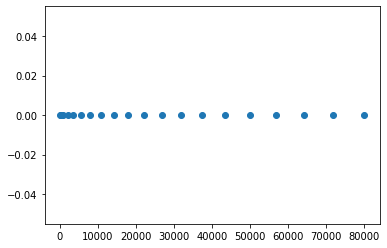

In [33]:
print(data_train.RUL.describe())
print(data_test.RUL.describe())

l=0.5
nb_bins = 20
lower_bin_bound = 0
upper_bin_bound = 80000

bins = np.linspace(lower_bin_bound, upper_bin_bound**(1-l), nb_bins)**(1/l)
labels=[i for i in range(bins.shape[0]-1)]
plt.plot(bins,np.full(bins.shape[0],0),'o')
print(bins)
print(labels)

data_train['RUL_bins'] = pd.cut(data_train['RUL'], bins=bins, labels=labels)
data_test['RUL_bins'] = pd.cut(data_test['RUL'], bins=bins, labels=labels)

display(data_train)
display(data_test)

# **Build Sequences**

In [34]:
#utils 
nb_gauges = 3
data_tr = data_train[data_train.ID <= 100]
data_val = data_test[data_test.ID <= 100]

#prepare forecasting data
def gen_X_sequence(id_df, seq_length, seq_cols,timesteps_pred,  type_data = None):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    
    
    ind_start = 0
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0+ind_start, num_elements-seq_length+1-timesteps_pred), range(seq_length+ind_start, num_elements+1-timesteps_pred)):
        yield data_array[start:stop, :]
 

def gen_Y_sequence(id_df, seq_length, seq_cols,timesteps_pred, type_data = None):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    
    
    ind_start = 0
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0+ind_start, num_elements-seq_length+1-timesteps_pred), range(seq_length+ind_start, num_elements+1-timesteps_pred)):
        yield data_array[stop-1, :]#data_array[start+1:stop+1, :]
   
#prepare data
seq_cols =  ['gauge'+str(i) for i in range(1,4)]#['label'+str(i) for i in range(1,4)]
seq_cols1 =  ['RUL_bins']
sequence_length = 30
timesteps_pred = 1



#training set
seq_gen = (list(gen_X_sequence(data_tr[data_tr['ID']==id], sequence_length, seq_cols, timesteps_pred, type_data= 'train')) 
                   for id in data_tr['ID'].unique())
# generate sequences and convert to numpy array
dbX = np.concatenate(list(seq_gen))



seq_gen = (list(gen_Y_sequence(data_tr[data_tr['ID']==id], sequence_length, seq_cols1, timesteps_pred, type_data= 'train')) 
                   for id in data_tr['ID'].unique())
# generate sequences and convert to numpy array
dbY = np.concatenate(list(seq_gen))#.astype(np.long).reshape(-1,)


print(dbX.shape)
print(dbY.shape)

# validation set
seq_gen = (list(gen_X_sequence(data_val[data_val['ID']==id], sequence_length, seq_cols, timesteps_pred, type_data= 'train')) 
                   for id in data_val['ID'].unique())

# generate sequences and convert to numpy array
dbX_val = np.concatenate(list(seq_gen))#.astype(np.long)

seq_gen = (list(gen_Y_sequence(data_val[data_val['ID']==id], sequence_length, seq_cols1, timesteps_pred, type_data= 'train')) 
                   for id in data_val['ID'].unique())
# generate sequences and convert to numpy array
dbY_val = np.concatenate(list(seq_gen))#.astype(np.long).reshape(-1,)

#test set
seq_gen = (list(gen_X_sequence(data_test[data_test['ID']==id], sequence_length, seq_cols, timesteps_pred, type_data= 'train')) 
                    for id in data_test['ID'].unique())
# generate sequences and convert to numpy array
dbX_test = np.concatenate(list(seq_gen))

seq_gen = (list(gen_Y_sequence(data_test[data_test['ID']==id], sequence_length, seq_cols1, timesteps_pred, type_data= 'train')) 
                    for id in data_test['ID'].unique())
# generate sequences and convert to numpy array
dbY_test = np.concatenate(list(seq_gen))



print(dbX_val.shape)
print(dbY_val.shape)

(10956, 30, 3)
(10956, 1)
(5782, 30, 3)
(5782, 1)


# **Normalize Data**

In [ ]:

print(dbX.shape)
dbX[:,:,0].max()
for k in range(3) :
  a = dbX[:,:,k].max()
  b = dbX[:,:,k].min()
  dbX[:,:,k] = (dbX[:,:,k] - b)/(a-b)
  dbX_val[:,:,k] = (dbX_val[:,:,k] - b)/(a-b)
  dbX_test[:,:,k] = (dbX_val[:,:,k] - b)/(a-b)


dbX
dbX_val
# train_dataset = tf.data.Dataset.from_tensor_slices((dbX, dbY)).batch(batch_size)
# val_dataset = tf.data.Dataset.from_tensor_slices((dbX_val, dbY_val)).batch(batch_size)
# test_dataset = tf.data.Dataset.from_tensor_slices((dbX_test, dbY_test)).batch(batch_size)


(10956, 30, 3)


array([[[0.99729747, 0.99973718, 0.27064718],
        [0.99704953, 0.99971295, 0.27079349],
        [0.99679565, 0.99968811, 0.27094334],
        ...,
        [0.98782114, 0.99879641, 0.27626327],
        [0.98731972, 0.99874579, 0.27656181],
        [0.98680352, 0.99869358, 0.2768693 ]],

       [[0.99704953, 0.99971295, 0.27079349],
        [0.99679565, 0.99968811, 0.27094334],
        [0.99653566, 0.99966266, 0.27109684],
        ...,
        [0.98731972, 0.99874579, 0.27656181],
        [0.98680352, 0.99869358, 0.2768693 ],
        [0.98627196, 0.99863973, 0.27718609]],

       [[0.99679565, 0.99968811, 0.27094334],
        [0.99653566, 0.99966266, 0.27109684],
        [0.99626935, 0.99963656, 0.27125411],
        ...,
        [0.98680352, 0.99869358, 0.2768693 ],
        [0.98627196, 0.99863973, 0.27718609],
        [0.98572445, 0.99858417, 0.27751255]],

       ...,

       [[0.99199199, 0.99921418, 0.27378536],
        [0.99160538, 0.9991757 , 0.27401464],
        [0.9912083 , 0

# **Build the model**

In [ ]:
dbY.shape

(10956, 20)

In [35]:
!pip install keras-tuner

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import kerastuner
from kerastuner.tuners import *
from kerastuner import HyperModel
from keras.wrappers.scikit_learn import KerasClassifier



class MyHyperModel(HyperModel):

    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def build(self, hp):
        # build model
        input_layer = Input(shape=(dbX.shape[1],dbX.shape[2]))
        x = LayerNormalization(axis=1)(input_layer)

        for i in range(hp.Int('num_layers', min_value=0, max_value=3, step=1)):
            x = LSTM(units=hp.Int('units', min_value=50, max_value=250, step=50), 
                     dropout=hp.Choice('Dropout',values=[0.0, 0.1, 0.2]),
                     recurrent_dropout=hp.Choice('Recurrent_Dropout',values=[0.0, 0.1, 0.2]), return_sequences=True)(x)
        x = LSTM(units=hp.Int('units', min_value=50, max_value=250, step=50), 
                 dropout=hp.Choice('Dropout',values=[0.0, 0.1, 0.2]), 
                 recurrent_dropout=hp.Choice('Recurrent_Dropout',values=[0.0, 0.1, 0.2]))(x)
        x = Activation('relu')(x)

        x = Dense(20, activation='softmax')(x)
        output_layer = x

        model = Model(input_layer, output_layer)

        # compile model
        model.compile(
            optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
            loss='sparse_categorical_crossentropy',
            metrics=['SparseCategoricalAccuracy'])

        return model


# **Compile and train**

In [ ]:
dbY.shape

(10956, 20)

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import *
from kerastuner.tuners import *
from kerastuner import HyperModel
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV



batch_size = 4096
sequence_length = 15


# # Create a MirroredStrategy.
# strategy = tf.distribute.MirroredStrategy()
# print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# # Open a strategy scope.
# with strategy.scope():
#     # Everything that creates variables should be under the strategy scope.
#     # In general this is only model construction & `compile()`.
hypermodel = MyHyperModel(input_shape = (dbX.shape[0], dbX.shape[1]), output_shape = dbY.shape[1])
tuner = RandomSearch(
    hypermodel,
    overwrite=True,
    objective='val_sparse_categorical_accuracy',
    max_trials=51)

tuner.search_space_summary()


val_dataset=tf.data.Dataset.from_tensor_slices((dbX_val, dbY_val)).batch(batch_size)
train_dataset=tf.data.Dataset.from_tensor_slices((dbX, dbY)).batch(batch_size)

tuner.search(train_dataset,
             epochs=500,
             verbose=2,
             validation_data=val_dataset,
             #callbacks=[tf.keras.callbacks.TensorBoard(tuner.directory + '/' + tuner.project_name)],
             )

models = tuner.get_best_models(num_models=1)

tuner.results_summary()

best_model = models[0]

model_path = tuner.directory + '/' + tuner.project_name + '/' + 'best_model'

# get model as json string and save to file
model_as_json = best_model.to_json()
with open(model_path + '.json', "w") as json_file:
    json_file.write(model_as_json)
# save model weights
best_model.save_weights(model_path + '_weights.h5')



  

Trial 23 Complete [00h 01m 07s]
val_sparse_categorical_accuracy: 0.5057073831558228

Best val_sparse_categorical_accuracy So Far: 0.5823244452476501
Total elapsed time: 04h 10m 10s

Search: Running Trial #24

Hyperparameter    |Value             |Best Value So Far 
num_layers        |3                 |1                 
units             |50                |50                
Dropout           |0.1               |0.2               
Recurrent_Dropout |0.2               |0.2               
learning_rate     |0.01              |0.01              

Epoch 1/500
3/3 - 12s - loss: 2.9787 - sparse_categorical_accuracy: 0.0395 - val_loss: 2.7027 - val_sparse_categorical_accuracy: 0.0237
Epoch 2/500
3/3 - 2s - loss: 2.8077 - sparse_categorical_accuracy: 0.0734 - val_loss: 2.4926 - val_sparse_categorical_accuracy: 0.2027
Epoch 3/500
3/3 - 2s - loss: 2.6993 - sparse_categorical_accuracy: 0.1126 - val_loss: 2.4360 - val_sparse_categorical_accuracy: 0.2027
Epoch 4/500
3/3 - 2s - loss: 2.6593 - spar

# **Evaluate**

181/181 [==============================] - 6s 36ms/step - loss: 0.7125 - accuracy: 0.6754


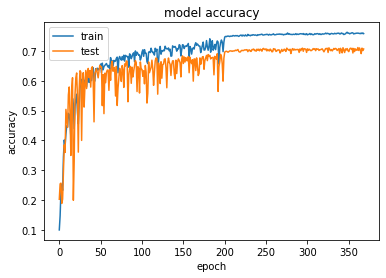

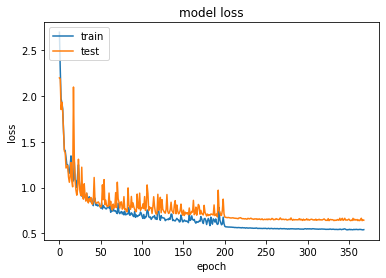

In [ ]:
model.evaluate(dbX_val, dbY_val, batch_size=32)
# summarize history for accuracy
acc = List_hist[0] + List_hist[4] + List_hist[8]        # concatenate history for the 3 learning rate to make it a single learning
val_acc = List_hist[1] + List_hist[5] + List_hist[9]
loss = List_hist[2] + List_hist[6] + List_hist[10]
val_loss = List_hist[3] + List_hist[7] + List_hist[11]
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()